## import library

In [ ]:
import pandas as pd
import numpy as np
import os
import re, string
from konlpy.tag import Komoran, Hannanum
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from keybert import KeyBERT


In [ ]:
path = os.getcwd() + '/2-2. keyword 추출/'
file_list = os.listdir(path + 'analysis/')

In [ ]:
data = pd.read_csv(file_list[0], encoding = 'utf-8-sig')
data_raw = data.copy()
#data_raw = data_raw.drop(['Unnamed: 0'], axis=1)
data_raw.head()

,date,abstract,pre_label,sentiment,score,sent_range
0,2022-01-03,"[유통가 이모저모] 신세계 정용진 부회장 ""우리 목표는 '제1의 신세계'"" ▲GS리...",1,0,3.644483,보통부정
1,2022-01-03,“시도하지 않은 슛은 100% 빗나간 것” 롯데·신세계 총수의 ‘그레츠키’ 인......,1,1,1.931253,중립
2,2022-01-03,"'물어보살' 클럽에 진심인 의뢰인..이수근 ""춤을 전문가처럼 추네""[별별TV] 의뢰...",1,1,1.980132,중립
3,2022-01-03,"""고객지향 기술혁신이 삼성전자 존립 근간"" 유통업계 라이벌인 신동빈 롯데 회장과 정...",1,1,2.050638,중립
4,2022-01-03,[일상으로 들어온 피지털] VR로 매장 구경하고 옷 피팅…온·오프 장점만 '쏙......,1,0,3.376113,강한부정


# 1. 전처리

In [ ]:
komoran = Komoran()
hannanum = Hannanum()

In [ ]:
def preprocess_data(data, data_colname):
    """
      tips: csv 데이터를 받아 지정된 column의 내용을 preprocess 합니다.
      Args:
          data_path : csv데이터의 path
          data_colname : 지정할 column명
      Returns:
          lucy_data : DataFrame
    """
    lucy_data = data

    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\(.*\)|\s-\s.*"," " ,regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\[.*\]|\s-\s.*"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\<.*\>|\s-\s.*"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("무단전재 및 재배포 금지"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("무단 전재 및 재배포 금지"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("©"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("ⓒ"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("저작권자"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace(".* 기자", " ", regex=True) #기자 이름에서 오는 유사도 차단
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("사진 = .*", " ", regex=True) #사진 첨부 문구 삭제
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("사진=.*", " ", regex=True) #사진 첨부 문구 삭제
    lucy_data[data_colname] = lucy_data[data_colname].str.replace('\"', "",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+.[a-zA-Z0-9-.]+)", " ", regex=True) #이메일 주소에서 오는 유사도 차단
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\n"," ")
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\r"," ")
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\t"," ")
    lucy_data[data_colname] = lucy_data[data_colname].str.replace( "\’" , "", regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("[ ]{2,}"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("?","",regex=True)
    
    return lucy_data

In [ ]:
# 불용어 파일 열기
with open(path + 'stopwords.txt', 'r', encoding='ISO-8859-1') as f:
    list_file = f.readlines() 
stopwords = list_file[0].split(",")

# 정규화, 특수기호 제거
def preprocess(text):
    text=text.str.strip()  
    text=re.compile('<.*?>').sub(' ', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', ' ', str(text).strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text


# 명사/영단어 추출, 한글자 제외, 불용어 제거
def final(text):
    n = []
    for i in range(len(text)):
      word = komoran.nouns(text[i])
      p = komoran.pos(text[i])
      for pos in p:
        if pos[1] in ['SL']:
          word.append(pos[0])
      for w in word:
        if len(w)>1 and w not in stopwords:
          n.append(w)
    return " ".join(n)

# 최종
def finalpreprocess(text):
  return final(text)

In [ ]:
data_raw['text'] = data_raw['abstract']
data_pre_2 = preprocess_data(data_raw, 'text')
data_pre_2['text'] = data_pre_2['text'].replace(' ', np.nan)
data_pre_2 = data_pre_2.dropna(axis=0)
data_pre_2 = data_pre_2.reset_index(drop=True)
data_pre_2['noun'] = finalpreprocess(data_pre_2['text'])

## 행 추출 : 핵심키워드만 있는 행만

In [ ]:
word_corpus = pd.read_csv(path + 'corpus_esg_keyword_v2.csv', encoding = 'utf-8-sig')
word_corpus = word_corpus['word'].values.tolist()
word_corpus

['폐기물',
 '사용량',
 '온실가스',
 '재활용',
 '원단위',
 '플라스틱',
 '배출량',
 '환경경영',
 '기후변화',
 'LED',
 'PET',
 '탄소중립',
 '사업장',
 '폐가전',
 '업사이클링',
 '음식물',
 '포장재',
 '페트병',
 '물류센터',
 '효율화',
 '코카콜라음료',
 '재활용성',
 '선순환',
 '환경',
 '지속적',
 '정보보호',
 '협력사',
 '안전보건',
 '동반성장',
 '협력회사',
 '개인정보',
 '임직원',
 '근로자',
 '프로그램',
 '정보보안',
 '중소기업',
 '개인정보보호',
 '온라인',
 '화학물질',
 '자율준수',
 '파트너사',
 '컨설팅',
 '경쟁력',
 '육아휴직',
 '유해물질',
 '공정거래',
 '시스템',
 '사업장',
 'ESG',
 '안심품질',
 '품질관리',
 '국내외',
 '프로세스',
 '안전성',
 '공급망',
 '화장품',
 '담당자',
 '안전사고',
 '안전관리',
 '간담회',
 '경영주',
 '플랫폼',
 '위험성',
 '불공정',
 '데이터',
 '매뉴얼',
 '지속적',
 '관리자',
 'HACCP',
 '품질경영',
 '산업재해',
 '전문기관',
 '가맹점',
 '안전보건경영',
 '윤리경영',
 '가이드라인',
 '제조사',
 '이사회',
 '이사회',
 '사내이사',
 '감사위원회',
 'ESG위원회',
 '주주총회',
 '참석률',
 '독립성',
 '위원회',
 '내부거래위원회',
 '지배구조',
 'ESG',
 '보상위원회',
 '대표이사',
 '경영진',
 '위원장',
 '전문성',
 '과반수']

In [ ]:
def extract_row(train):  #train은 dataframe

		# join함수를 이용하여 이어주고 contains 함수에 넣기
		user_keywords = '|'.join(word_corpus)
		temp = train[train['noun'].str.contains(user_keywords)]
		train_extract = temp[['date', 'abstract', 'text', 'pre_label', 'sentiment', 'score', 'sent_range']]
		train_extract
		return train_extract

# 한나눔 전처리
def final_han(text):
    n = []
    word = hannanum.nouns(text)
    p = hannanum.pos(text)
    for pos in p:
      if pos[1] in ['F']:
        word.append(pos[0])
    for w in word:
      if len(w)>1 and w not in stopwords:
        n.append(w)
    return " ".join(n)

# 최종
def finalpreprocess_han(text):
  return final_han(text)

In [ ]:
data_extract = extract_row(data_pre_2)
data_extract = preprocess_data(data_extract, 'text')
data_extract['text'] = data_extract['text'].replace(' ', np.nan)
data_extract = data_extract.dropna(axis=0)
data_extract = data_extract.reset_index(drop=True)

data_extract['noun'] = data_extract['text'].apply(lambda x: finalpreprocess_han(x))

,date,abstract,text,pre_label,sentiment,score,sent_range,noun
0,2022-01-03,"[유통가 이모저모] 신세계 정용진 부회장 ""우리 목표는 '제1의 신세계'"" ▲GS리...",신세계 정용진 부회장 우리 목표는 제 의 신세계 리테일 허연수 는 일 오전 타워 ...,1,0,3.644483,보통부정,신세계 정용진 부회장 우리 목표 신세계 리테 허연수 오전 타워 리테일 비전 선포식 ...
1,2022-01-03,“시도하지 않은 슛은 100% 빗나간 것” 롯데·신세계 총수의 ‘그레츠키’ 인......,시도하지 않은 슛은 빗나간 것 롯데 신세계 총수의 그레츠키 인 유통업계 최대 맞수...,1,1,1.931253,중립,시도 롯데 신세계 총수 그레츠키 유통업계 최대 맞수 롯데 신세계 신년사 우리 목표 ...
2,2022-01-03,"'물어보살' 클럽에 진심인 의뢰인..이수근 ""춤을 전문가처럼 추네""[별별TV] 의뢰...",물어보살 클럽에 진심인 의뢰인 이수근 춤을 전문가처럼 추네 의뢰인은 처음으로 살 ...,1,1,1.980132,중립,물어보살 클럽 진심 의뢰인 이수근 전문가 의뢰인 처음 클럽 신세계 서장훈 여자친구 ...
3,2022-01-03,"""고객지향 기술혁신이 삼성전자 존립 근간"" 유통업계 라이벌인 신동빈 롯데 회장과 정...",고객지향 기술혁신이 삼성전자 존립 근간 유통업계 라이벌인 신동빈 롯데 회장과 정용진...,1,1,2.050638,중립,고객지향 기술혁신 삼성전자 존립 근간 유통업계 라이벌 신동빈 롯데 회장 정용진 신세...
4,2022-01-03,[일상으로 들어온 피지털] VR로 매장 구경하고 옷 피팅…온·오프 장점만 '쏙......,로 매장 구경하고 옷 피팅 온 오프 장점만 쏙 신세계는 익스프레쓱 을 롯데온은 스...,1,0,3.376113,강한부정,매장 구경 피팅 오프 장점 신세계 익스프레쓱 롯데온 스마트픽 런칭했다 자사 온라인 ...
...,...,...,...,...,...,...,...,...
1668,2023-01-13,[브리프]현대백화점 이마트 롯데마트 홈플러스 신세계사이먼 G마켓 GS25 세븐......,현대백화점 이마트 롯데마트 홈플러스 신세계사이먼 마켓 세븐 와 익산농협은 이달 일...,1,1,2.050638,중립,현대백화점 이마트 롯데마트 홈플러스 신세계사이먼 마켓 세븐 익산농협 이달 전라북 익...
1669,2023-01-13,‘高등어’된 국민생선 어획량 줄어 1년새 국내산 가격 2배 ‘껑충’ 2500세트가 ...,등어된 국민생선 어획량 줄어 년새 국내산 가격 배 껑충 세트가 팔렸던 것을 고려하...,1,1,2.158180,약한긍정,등어된 국민생선 어획량 년새 국내산 가격 세트 방송당 리테 관계자 노르웨 고등어 수...
1670,2023-01-13,[Who Is ?] 구현모 KT 대표이사 사장 KT는 브라이트 사업을 시작할 때 G...,구현모 대표이사 사장 는 브라이트 사업을 시작할 때 리테일과 손잡고 전국에 가상현...,1,1,2.050638,중립,구현모 대표이사 사장 브라이트 사업 시작 리테일 전국 가상현실 테마파크 지점 계획 ...
1671,2023-01-13,"[산업 이모저모] LG엔솔-혼다, 美 배터리 합작공장 설립...""북미 전기차 시장....",엔솔 혼다 배터리 합작공장 설립 북미 전기차 시장 추첨을 통해 시승 고객에게는 스...,1,2,1.488642,중립,엔솔 혼다 배터리 합작공장 설립 북미 전기차 시장 추첨 시승 고객 스타벅스 기프티콘...


## 클러스터링 #1 : 중복기사 or 공시 문장 제거

In [ ]:
text = data_extract['noun']

In [ ]:
#1 tf-idf 임베딩(+Normalize)
def tfidf_vectorizer(text, min_df=3, ngram_range=(1,5)):
    tfidf_vectorizer = TfidfVectorizer(min_df = 3, ngram_range=(1,5)) #min_df :최소 빈도값 (단어 등장하는 문서 수)
    tfidf_vectorizer.fit(text)
    vector = tfidf_vectorizer.transform(text).toarray()
    vector = np.array(vector) # Normalizer를 이용해 이미 변환된 벡터
    return vector

vector_1st = tfidf_vectorizer(text, min_df=1)

In [ ]:
#2 DBSCAN Clustering

model = DBSCAN(eps=0.1,min_samples=1, metric = "cosine") 
#     거리 계산 식으로는 Cosine distance를 이용
#     eps이 낮을수록, min_samples 값이 높을수록 군집으로 판단하는 기준이 까다로움.
result_1st = model.fit_predict(vector_1st)
data_extract['cluster1st'] = result_1st

print('군집개수 :', result_1st.max())
data_extract

군집개수 : 1665


,date,abstract,text,pre_label,sentiment,score,sent_range,noun,cluster1st
0,2022-01-03,"[유통가 이모저모] 신세계 정용진 부회장 ""우리 목표는 '제1의 신세계'"" ▲GS리...",신세계 정용진 부회장 우리 목표는 제 의 신세계 리테일 허연수 는 일 오전 타워 ...,1,0,3.644483,보통부정,신세계 정용진 부회장 우리 목표 신세계 리테 허연수 오전 타워 리테일 비전 선포식 ...,0
1,2022-01-03,“시도하지 않은 슛은 100% 빗나간 것” 롯데·신세계 총수의 ‘그레츠키’ 인......,시도하지 않은 슛은 빗나간 것 롯데 신세계 총수의 그레츠키 인 유통업계 최대 맞수...,1,1,1.931253,중립,시도 롯데 신세계 총수 그레츠키 유통업계 최대 맞수 롯데 신세계 신년사 우리 목표 ...,1
2,2022-01-03,"'물어보살' 클럽에 진심인 의뢰인..이수근 ""춤을 전문가처럼 추네""[별별TV] 의뢰...",물어보살 클럽에 진심인 의뢰인 이수근 춤을 전문가처럼 추네 의뢰인은 처음으로 살 ...,1,1,1.980132,중립,물어보살 클럽 진심 의뢰인 이수근 전문가 의뢰인 처음 클럽 신세계 서장훈 여자친구 ...,2
3,2022-01-03,"""고객지향 기술혁신이 삼성전자 존립 근간"" 유통업계 라이벌인 신동빈 롯데 회장과 정...",고객지향 기술혁신이 삼성전자 존립 근간 유통업계 라이벌인 신동빈 롯데 회장과 정용진...,1,1,2.050638,중립,고객지향 기술혁신 삼성전자 존립 근간 유통업계 라이벌 신동빈 롯데 회장 정용진 신세...,3
4,2022-01-03,[일상으로 들어온 피지털] VR로 매장 구경하고 옷 피팅…온·오프 장점만 '쏙......,로 매장 구경하고 옷 피팅 온 오프 장점만 쏙 신세계는 익스프레쓱 을 롯데온은 스...,1,0,3.376113,강한부정,매장 구경 피팅 오프 장점 신세계 익스프레쓱 롯데온 스마트픽 런칭했다 자사 온라인 ...,4
...,...,...,...,...,...,...,...,...,...
1668,2023-01-13,[브리프]현대백화점 이마트 롯데마트 홈플러스 신세계사이먼 G마켓 GS25 세븐......,현대백화점 이마트 롯데마트 홈플러스 신세계사이먼 마켓 세븐 와 익산농협은 이달 일...,1,1,2.050638,중립,현대백화점 이마트 롯데마트 홈플러스 신세계사이먼 마켓 세븐 익산농협 이달 전라북 익...,1661
1669,2023-01-13,‘高등어’된 국민생선 어획량 줄어 1년새 국내산 가격 2배 ‘껑충’ 2500세트가 ...,등어된 국민생선 어획량 줄어 년새 국내산 가격 배 껑충 세트가 팔렸던 것을 고려하...,1,1,2.158180,약한긍정,등어된 국민생선 어획량 년새 국내산 가격 세트 방송당 리테 관계자 노르웨 고등어 수...,1662
1670,2023-01-13,[Who Is ?] 구현모 KT 대표이사 사장 KT는 브라이트 사업을 시작할 때 G...,구현모 대표이사 사장 는 브라이트 사업을 시작할 때 리테일과 손잡고 전국에 가상현...,1,1,2.050638,중립,구현모 대표이사 사장 브라이트 사업 시작 리테일 전국 가상현실 테마파크 지점 계획 ...,1663
1671,2023-01-13,"[산업 이모저모] LG엔솔-혼다, 美 배터리 합작공장 설립...""북미 전기차 시장....",엔솔 혼다 배터리 합작공장 설립 북미 전기차 시장 추첨을 통해 시승 고객에게는 스...,1,2,1.488642,중립,엔솔 혼다 배터리 합작공장 설립 북미 전기차 시장 추첨 시승 고객 스타벅스 기프티콘...,1664


In [ ]:
def print_cluster_result(train, result, col_cluster):
    # train : 데이터, result : 군집화 결과, col_cluster : 클러스터넘버 컬럼명
    clusters = []
    date = []
    abstract = []
    counts = []
    titles = []
    urls = []
    thumbnails = []
    range = []
    nouns = []
    labels = []
    for cluster_num in set(result):
            print("cluster num : {}".format(cluster_num))
            temp_df = train[train[col_cluster] == cluster_num] # cluster num 별로 조회
            clusters.append(cluster_num)
            counts.append(len(temp_df))
            date.append(temp_df.reset_index()['date'][0])
            abstract.append(temp_df.reset_index()['abstract'][0])
            #titles.append(temp_df.reset_index()['title'][0])
            #urls.append(temp_df.reset_index()['contents'][0])
            thumbnails.append(temp_df.reset_index()['score'][0])
            urls.append(temp_df.reset_index()['sentiment'][0])
            titles.append(temp_df.reset_index()['text'][0])
            range.append(temp_df.reset_index()['sent_range'][0])
            nouns.append(temp_df.reset_index()['noun'][0]) 
            labels.append(temp_df.reset_index()['pre_label'][0])

            for title in temp_df['text']:
                print(title) # 제목으로 살펴보자
            print()

    cluster_result = pd.DataFrame({'date':date, 'cluster_num':clusters, 'count':counts, 'abstract':abstract, 'text': titles, 'pre_label':labels, 'sentiment':urls, 'score':thumbnails, 'sent_range':range, 'noun': nouns})
    return cluster_result


In [ ]:
cluster1_result = print_cluster_result( train=data_extract, 
                                       result=result_1st, col_cluster="cluster1st")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

cluster num : 2
 물어보살 클럽에 진심인 의뢰인 이수근 춤을 전문가처럼 추네 의뢰인은 처음으로 살 때 클럽에 갔는데 신세계더라고 하자 서장훈은 여자친구는 없냐라고 물었다 의뢰인은 여자친구 안 사귄 지 년째다고 말하며 클럽에 대한 애정을 보였다 이에 이수근은 의뢰인이 춤을 출 

cluster num : 3
고객지향 기술혁신이 삼성전자 존립 근간 유통업계 라이벌인 신동빈 롯데 회장과 정용진 신세계 부회장은 시도조차 하지 않은 샷은 빗나간다 는 캐나다 아이스하키 선수 웨인 그레츠키의 말을 나란히 인용하며 도전정신과 실패도 포용하는 조직문화의 

cluster num : 4
 로 매장 구경하고 옷 피팅 온 오프 장점만 쏙 신세계는 익스프레쓱 을 롯데온은 스마트픽 을 런칭했다 자사 온라인 쇼핑몰에서 주문한 상품을 매장에서 직접 확인 수령하는 서비스다 온라인 혜택을 챙김과 동시에 현장에서 사이즈 교환과 수선이 가능하다 

cluster num : 5
 물어보살 임성민 스승 제이블랙 전화에 붉어진 눈시울 잘 지내고 있어 살에 나이트클럽에 갔는데 신세계더라 여러 지역 클럽을 다니다가 안양에 정착했다 여자들의 반응이 난리 나는 편이다라고 이야기했다 임성민은 댄스 뮤지컬 동아리 하다가 클럽에서 홀로 실력을 연마했다 이후 

cluster num : 6
 허연수 리테일 대표이사 는 일 임인년은 진정한 통합 리테일로 거듭나 유통시장의 절대 강자로 

cluster num : 7
 유통 절대강자 포부 밝힌 허연수 년 리테일 도약의 원년 지난해 그룹 유통 부문 통합법인으로 거듭난 리테일이 고객의 모든 경험을 연결하고 데이터로 공감하며 상품과 서비스로 신뢰 받는 플랫폼으로 거듭나겠다는 청사진을 제시했다 허연수 리테일 부회장 은 

cluster num : 8
 수상해야 생존한다 유통 라이벌인 신동빈 롯데그룹 회장과 정용진 신세계그룹 부회장은 시도조차 하지 않는 샷은 빗나간다는 아이스하키 전설 웨인 그레츠키의

## 클러스터링 #2 : 관련 기사 혹은 공시 문장 군집화

In [ ]:
text2 = cluster1_result['noun']
vector_2nd = tfidf_vectorizer(text2, min_df=1)

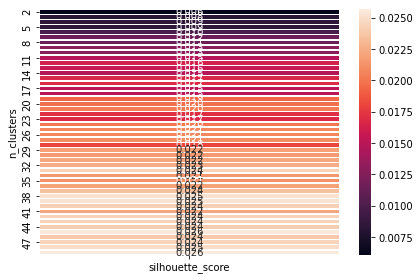

In [ ]:
# Silhouette Score - 최적 k
def visualize_silhouette_layer(data, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2,50)
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

visualize_silhouette_layer(vector_2nd) # 가장 높은 실루엣 계수와 매핑되는 k

In [ ]:
# kmeans 군집 결과 확인
from sklearn.cluster import KMeans

result_2nd = KMeans(n_clusters=49).fit_predict(vector_2nd)
cluster1_result['cluster2nd'] = result_2nd

cluster2_result = print_cluster_result( train=cluster1_result, 
                                       result=result_2nd, col_cluster="cluster2nd")

cluster num : 0
 신세계 정용진 부회장 우리 목표는 제 의 신세계 리테일 허연수 는 일 오전 타워 층에서 열린 리테일의 새로운 비전 선포식 에서 고객의 모든 경험을 연결하고 데이터로 공감하며 상품과 서비스로 신뢰 받는 플랫폼 기업으로 거듭나겠다는 
 허연수 리테일 대표이사 는 일 임인년은 진정한 통합 리테일로 거듭나 유통시장의 절대 강자로 
 유통 절대강자 포부 밝힌 허연수 년 리테일 도약의 원년 지난해 그룹 유통 부문 통합법인으로 거듭난 리테일이 고객의 모든 경험을 연결하고 데이터로 공감하며 상품과 서비스로 신뢰 받는 플랫폼으로 거듭나겠다는 청사진을 제시했다 허연수 리테일 부회장 은 
신성장 동력 찾아라 유통가 벤처 투자 열풍 리테일은 지난해 홈쇼핑을 흡수 합병하며 미래성장 동력을 발굴하는 신사업 조직을 전략본부 산하로 통합했다 또 그룹은 지난달 단행한 년 임원인사에서 이성화 리테일 신사업부문장을 상무로 승진시키며 
 유통기업 포스트코로나 적극 로 채비중 리테일은 작년 샵과 통합한 후 물류분야에만 물류분야에 억 원 투자를 단행했다 시사포커스 리테일은 샵과 작년 월 통합했다 리테일은 물류 신사업 등에 년간 조 원을 투입해 초대형 물류 
네 카 잡으려다 혁신 스타트업만 고사될판 플랫폼 심사지침 에 뿔난 스 중고 거래 플랫폼 위인 당근마켓은 리테일 롯데쇼핑 신세계 등 최근 해당 사업에 뛰어든 유통 공룡들과 경쟁해야 한다 온라인 플랫폼 중개 거래의 공정화에 관한 법률안 이 아직 국회를 통과하지 못한 
 그래픽 뉴스 적중 애널리스트 전무 종목 한온시스템 리테일 한국금융지주 현대건설기계 효성첨단소재 더존비즈온 카카오 에코마케팅 등 개 종목 에 달하는 것으로 나타났다 증권사가 제시한 목표가 적중률은 월 후 종가 년 
불확실성의 시대 생태계 확장나선 리테일은 데이터 중심의 고객만족 최우선 경영을 위해 온 오프라인 전 채널에서 수집되는 빅데이터를 통합 활용해 개인화 마케팅 역량을 강화하고 리테일의 채널 내에서 생애 주기 별로 새로운 고객 경험을 
 스마트시티 에

In [ ]:
# cluster2_result.to_csv('/content/drive/MyDrive/와이빅타/DA_주니어플젝/final_cluster2_result.csv', index=False)
# cluster1_result.to_csv('/content/drive/MyDrive/와이빅타/DA_주니어플젝/final_cluster1_result.csv', index=False)

## keyword 추출

In [ ]:
key_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2')  #distilbert-base-nli-mean-tokens / paraphrase-multilingual-MiniLM-L12-v2

In [ ]:
def model_keyword(data, col_cluster, corpus):  #data = cluster_result (데이터프레임) #1분 30초 소요됨
    result = []
    for i in range(len(data)):
        key_text = cluster1_result[cluster1_result[col_cluster]==i]['noun']
        key_text = ' '.join(key_text)
        keyword = key_model.extract_keywords(key_text, keyphrase_ngram_range=(1,2), top_n=1)
        result.append(keyword[0][0])
    return result

def corpus_keyword(data, col_cluster, corpus):  #data = cluster_result (데이터프레임) #1분 30초 소요됨
    result = []
    for i in range(len(data)):
        start = 1
        key_text = cluster1_result[cluster1_result[col_cluster]==i]['noun']
        key_text = ' '.join(key_text)
        keyword = key_model.extract_keywords(key_text, keyphrase_ngram_range=(1,2), top_n=10)
        for j in range(len(keyword)):
          if start == 1:
            for q in range(len(corpus)):
              if corpus[q] in keyword[j][0]:
                result.append(corpus[q])
                start = 0
                break
              else:
                pass
            if j == len(keyword)-1:
              result.append(' ')
              start = 0 
              break
    return result

def keyword_in_corpus(corpus, keyword):
    for j in range(len(corpus)):
        if keyword in corpus[j]:
            return corpus[j]
        elif j == len(corpus)-1:
            return ' '

def merge_keyword(data, col_cluster, corpus): #새 열로 추가.
    data_temp = data.copy()
    data_temp['model_keyword'] = model_keyword(data, col_cluster, corpus)
    data_temp['corpus_keyword'] = corpus_keyword(data, col_cluster, corpus)
    return data_temp

keyword_result = merge_keyword(cluster2_result, col_cluster='cluster2nd', corpus = word_corpus)

keyword_df = keyword_result[['cluster_num', 'count', 'model_keyword', 'corpus_keyword']]
keyword_df.sort_values(by='count', ascending=False, inplace=True, ignore_index=True)
keyword_df.drop(index=[0], inplace=True)
keyword_df = keyword_df[keyword_df['count']>5]
lst_1 = []
lst_2 = []
for i in keyword_df['model_keyword']:
  lst_1.append(i.upper())
for i in keyword_df['corpus_keyword']:
  lst_2.append(i.upper())
keyword_df['model_keyword'] = lst_1
keyword_df['corpus_keyword'] = lst_2
keyword_df


/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,cluster_num,count,model_keyword,corpus_keyword
1,17,37,할인행사 이마트,
2,42,36,갤러리아백화점 롯데백화점,
3,7,34,두산인프라코 회장,
4,41,32,잠실롯데월드몰 신세계백화점강남,
5,2,32,쇼핑몰 불모지,
6,13,29,내달 광주신세계갤러리,환경
7,3,28,체결 광진문화재단,파트너사
8,11,27,신세계그룹 조선호텔앤리조트,대표이사
9,40,25,트위터 광주신세계복합쇼핑몰,
10,14,25,수료생들 삼성전자,


# 5. 최종 데이터

In [ ]:
cluster1_result

,date,cluster_num,count,abstract,text,pre_label,sentiment,score,sent_range,noun,cluster2nd
0,2022-01-03,0,1,"[유통가 이모저모] 신세계 정용진 부회장 ""우리 목표는 '제1의 신세계'"" ▲GS리...",신세계 정용진 부회장 우리 목표는 제 의 신세계 리테일 허연수 는 일 오전 타워 ...,1,0,3.644483,보통부정,신세계 정용진 부회장 우리 목표 신세계 리테 허연수 오전 타워 리테일 비전 선포식 ...,0
1,2022-01-03,1,1,“시도하지 않은 슛은 100% 빗나간 것” 롯데·신세계 총수의 ‘그레츠키’ 인......,시도하지 않은 슛은 빗나간 것 롯데 신세계 총수의 그레츠키 인 유통업계 최대 맞수...,1,1,1.931253,중립,시도 롯데 신세계 총수 그레츠키 유통업계 최대 맞수 롯데 신세계 신년사 우리 목표 ...,45
2,2022-01-03,2,1,"'물어보살' 클럽에 진심인 의뢰인..이수근 ""춤을 전문가처럼 추네""[별별TV] 의뢰...",물어보살 클럽에 진심인 의뢰인 이수근 춤을 전문가처럼 추네 의뢰인은 처음으로 살 ...,1,1,1.980132,중립,물어보살 클럽 진심 의뢰인 이수근 전문가 의뢰인 처음 클럽 신세계 서장훈 여자친구 ...,16
3,2022-01-03,3,1,"""고객지향 기술혁신이 삼성전자 존립 근간"" 유통업계 라이벌인 신동빈 롯데 회장과 정...",고객지향 기술혁신이 삼성전자 존립 근간 유통업계 라이벌인 신동빈 롯데 회장과 정용진...,1,1,2.050638,중립,고객지향 기술혁신 삼성전자 존립 근간 유통업계 라이벌 신동빈 롯데 회장 정용진 신세...,28
4,2022-01-03,4,1,[일상으로 들어온 피지털] VR로 매장 구경하고 옷 피팅…온·오프 장점만 '쏙......,로 매장 구경하고 옷 피팅 온 오프 장점만 쏙 신세계는 익스프레쓱 을 롯데온은 스...,1,0,3.376113,강한부정,매장 구경 피팅 오프 장점 신세계 익스프레쓱 롯데온 스마트픽 런칭했다 자사 온라인 ...,7
...,...,...,...,...,...,...,...,...,...,...,...
1661,2023-01-13,1661,1,[브리프]현대백화점 이마트 롯데마트 홈플러스 신세계사이먼 G마켓 GS25 세븐......,현대백화점 이마트 롯데마트 홈플러스 신세계사이먼 마켓 세븐 와 익산농협은 이달 일...,1,1,2.050638,중립,현대백화점 이마트 롯데마트 홈플러스 신세계사이먼 마켓 세븐 익산농협 이달 전라북 익...,1
1662,2023-01-13,1662,1,‘高등어’된 국민생선 어획량 줄어 1년새 국내산 가격 2배 ‘껑충’ 2500세트가 ...,등어된 국민생선 어획량 줄어 년새 국내산 가격 배 껑충 세트가 팔렸던 것을 고려하...,1,1,2.158180,약한긍정,등어된 국민생선 어획량 년새 국내산 가격 세트 방송당 리테 관계자 노르웨 고등어 수...,41
1663,2023-01-13,1663,1,[Who Is ?] 구현모 KT 대표이사 사장 KT는 브라이트 사업을 시작할 때 G...,구현모 대표이사 사장 는 브라이트 사업을 시작할 때 리테일과 손잡고 전국에 가상현...,1,1,2.050638,중립,구현모 대표이사 사장 브라이트 사업 시작 리테일 전국 가상현실 테마파크 지점 계획 ...,43
1664,2023-01-13,1664,1,"[산업 이모저모] LG엔솔-혼다, 美 배터리 합작공장 설립...""북미 전기차 시장....",엔솔 혼다 배터리 합작공장 설립 북미 전기차 시장 추첨을 통해 시승 고객에게는 스...,1,2,1.488642,중립,엔솔 혼다 배터리 합작공장 설립 북미 전기차 시장 추첨 시승 고객 스타벅스 기프티콘...,11


In [ ]:
cluster1_result[['date', 'abstract', 'text', 'pre_label', 'sentiment', 'score', 'sent_range', 'cluster2nd']]

,date,abstract,text,pre_label,sentiment,score,sent_range,cluster2nd
0,2022-01-03,"[유통가 이모저모] 신세계 정용진 부회장 ""우리 목표는 '제1의 신세계'"" ▲GS리...",신세계 정용진 부회장 우리 목표는 제 의 신세계 리테일 허연수 는 일 오전 타워 ...,1,0,3.644483,보통부정,0
1,2022-01-03,“시도하지 않은 슛은 100% 빗나간 것” 롯데·신세계 총수의 ‘그레츠키’ 인......,시도하지 않은 슛은 빗나간 것 롯데 신세계 총수의 그레츠키 인 유통업계 최대 맞수...,1,1,1.931253,중립,45
2,2022-01-03,"'물어보살' 클럽에 진심인 의뢰인..이수근 ""춤을 전문가처럼 추네""[별별TV] 의뢰...",물어보살 클럽에 진심인 의뢰인 이수근 춤을 전문가처럼 추네 의뢰인은 처음으로 살 ...,1,1,1.980132,중립,16
3,2022-01-03,"""고객지향 기술혁신이 삼성전자 존립 근간"" 유통업계 라이벌인 신동빈 롯데 회장과 정...",고객지향 기술혁신이 삼성전자 존립 근간 유통업계 라이벌인 신동빈 롯데 회장과 정용진...,1,1,2.050638,중립,28
4,2022-01-03,[일상으로 들어온 피지털] VR로 매장 구경하고 옷 피팅…온·오프 장점만 '쏙......,로 매장 구경하고 옷 피팅 온 오프 장점만 쏙 신세계는 익스프레쓱 을 롯데온은 스...,1,0,3.376113,강한부정,7
...,...,...,...,...,...,...,...,...
1661,2023-01-13,[브리프]현대백화점 이마트 롯데마트 홈플러스 신세계사이먼 G마켓 GS25 세븐......,현대백화점 이마트 롯데마트 홈플러스 신세계사이먼 마켓 세븐 와 익산농협은 이달 일...,1,1,2.050638,중립,1
1662,2023-01-13,‘高등어’된 국민생선 어획량 줄어 1년새 국내산 가격 2배 ‘껑충’ 2500세트가 ...,등어된 국민생선 어획량 줄어 년새 국내산 가격 배 껑충 세트가 팔렸던 것을 고려하...,1,1,2.158180,약한긍정,41
1663,2023-01-13,[Who Is ?] 구현모 KT 대표이사 사장 KT는 브라이트 사업을 시작할 때 G...,구현모 대표이사 사장 는 브라이트 사업을 시작할 때 리테일과 손잡고 전국에 가상현...,1,1,2.050638,중립,43
1664,2023-01-13,"[산업 이모저모] LG엔솔-혼다, 美 배터리 합작공장 설립...""북미 전기차 시장....",엔솔 혼다 배터리 합작공장 설립 북미 전기차 시장 추첨을 통해 시승 고객에게는 스...,1,2,1.488642,중립,11


In [ ]:
temp_df = cluster1_result[['date', 'abstract', 'text', 'pre_label', 'sentiment', 'score', 'sent_range', 'cluster2nd']]
final = temp_df.merge(keyword_df, left_on='cluster2nd', right_on='cluster_num').drop(columns=['count'])
final = final.drop(columns=['text', 'cluster2nd', 'cluster_num'])

In [ ]:
final.to_csv(path + 'analysis/output/' + file_list[0] + '/final_merge.csv', index=False, encoding = 'utf-8-sig')